In [1]:
# import libraries
import torch
import os
import pandas
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Dataset
from torchvision.models import resnet50
from torchvision.models.resnet import ResNet50_Weights

In [2]:
# define the super parameters
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# define SaveImagesToCSV Class
class SaveImagesToCSV:
    def __init__(self,root="./data", train = True, transforms=None):
        self.root = root
        self.pre = "/train_set/" if train else "/test_set/"
        self.count = 0
        self.labels = []
        self.data = []
        self.nums = [4468, 4381, 4254] if train else [865, 899, 878]
        self.names = ["O/","V/","W/"]
        self.transforms = transforms
        for i in range(3):
            name = self.names[i]
            for j in range(self.nums[i]):
                self.data.append(self.root+self.pre+name+str(j)+".jpg")
                self.labels.append(i)
                self.count += 1
        
        df = pandas.DataFrame({'image_path': self.data, 'label': self.labels})
        if train:
            df.to_csv('./data/train_set/train_images.csv', index=False)
        else:
            df.to_csv('./data/test_set/test_images.csv', index=False)
    

In [4]:
# def DataLoader class
class Dataset(Dataset):
    def __init__(self, csv_file, transforms = None):
        if not os.path.exists(csv_file):
            print('CSV file not found')
            return
        self.dataframe = pandas.read_csv(csv_file)
        self.transform = transforms

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx, 0]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        label = self.dataframe.iloc[idx, 1]
        return image, label

In [5]:
# define the loss function
criterion = nn.CrossEntropyLoss()

In [6]:
# define the train function
def train(model, device, train_loader, optimizer,epoch):
    model.train()
    train_loss = 0
    for (data, target) in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        torch.cuda.empty_cache()

    train_loss /= len(train_loader.dataset)
    print ('Epoch: {}'.format(epoch))
    print('Average train Loss: {:.6f}'.format(train_loss))

In [7]:
# define test function
def test(model, device, test_loader):
    model.eval()
    model.to(device)
    test_loss = 0
    correct = 0
    image_counter = 0

    classes = ['Rock','Scissors','Paper']

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            predict = output.argmax(dim=1, keepdim=True)
            correct += predict.eq(target.view_as(predict)).sum().item()
            
            # 显示图像和预测结果
            for i in range(data.size(0)):
                if image_counter >= 3:
                    break
                image = data[i].cpu().numpy().transpose((1, 2, 0))

                plt.imshow(image, cmap='gray')
                plt.title("Predict: {}".format(classes[predict[i].item()]))
                plt.axis('off')
                image_counter += 1

            # 显示图形
            plt.show()
                
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('Average test Loss: {:.6f}'.format(test_loss))
    print('Accuracy: {}/{} ({:.2f}%)'.format(correct, len(test_loader.dataset), accuracy))
    return test_loss, accuracy

In [8]:
# define the transform
transformations= transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(180),
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,))
])

In [9]:
# save the images to csv
save_train_images = SaveImagesToCSV(root="./data", train=True)
save_test_images = SaveImagesToCSV(root="./data", train=False)


In [10]:
# 加load train and test dataset
train_dataset = Dataset(csv_file='./data/train_set/train_images.csv', transforms=transformations)
test_dataset = Dataset(csv_file="./data/test_set/test_images.csv", transforms=transformations)

In [11]:
# create the data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [12]:
# create the model and modify the last layer
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 3)


In [13]:
# move the model to the GPU device
model = model.to(device)

# define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

Epoch: 1
Average train Loss: 0.014980


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


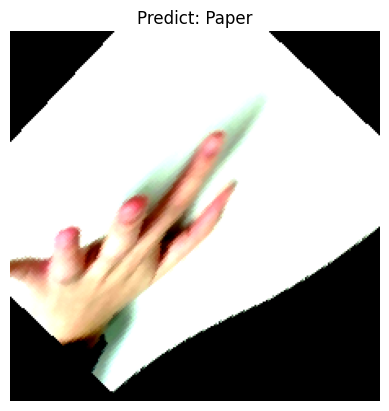

Average test Loss: 0.012481
Accuracy: 2259/2642 (85.50%)
Model saved
Model saved with test loss: 0.012481
Model saved with accuracy: 85.50%

Epoch: 2
Average train Loss: 0.009824


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


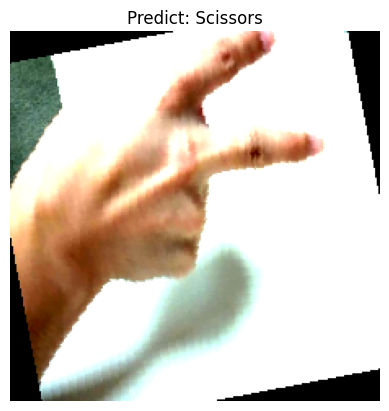

Average test Loss: 0.007882
Accuracy: 2414/2642 (91.37%)
Model saved
Model saved with test loss: 0.007882
Model saved with accuracy: 91.37%

Epoch: 3
Average train Loss: 0.006251


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


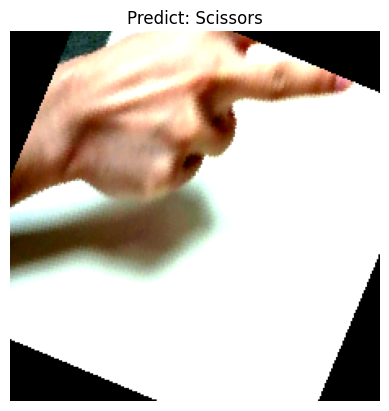

Average test Loss: 0.005122
Accuracy: 2486/2642 (94.10%)
Model saved
Model saved with test loss: 0.005122
Model saved with accuracy: 94.10%

Epoch: 4
Average train Loss: 0.004375


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


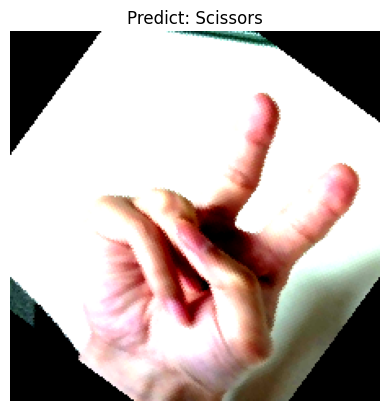

Average test Loss: 0.003826
Accuracy: 2508/2642 (94.93%)
Model saved
Model saved with test loss: 0.003826
Model saved with accuracy: 94.93%

Epoch: 5
Average train Loss: 0.003328


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


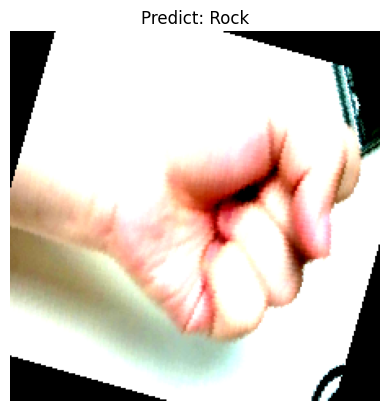

Average test Loss: 0.003144
Accuracy: 2503/2642 (94.74%)
Model saved
Model saved with test loss: 0.003144
Model saved with accuracy: 94.74%

Epoch: 6
Average train Loss: 0.002664


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


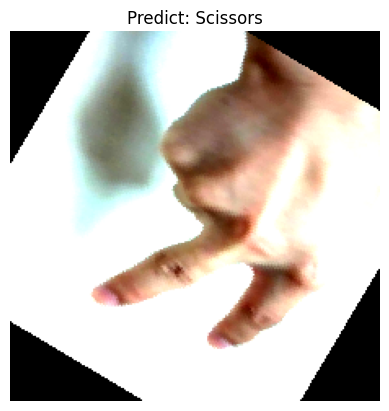

Average test Loss: 0.002501
Accuracy: 2540/2642 (96.14%)
Model saved
Model saved with test loss: 0.002501
Model saved with accuracy: 96.14%

Epoch: 7
Average train Loss: 0.002225


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


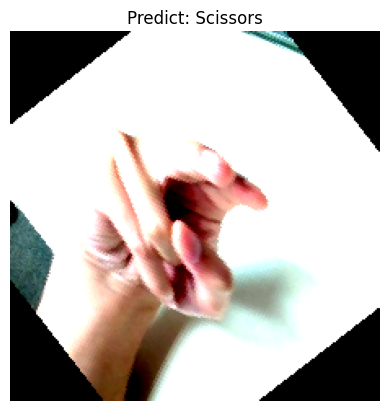

Average test Loss: 0.002346
Accuracy: 2529/2642 (95.72%)
Model saved
Model saved with test loss: 0.002346
Model saved with accuracy: 95.72%

Epoch: 8
Average train Loss: 0.001870


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


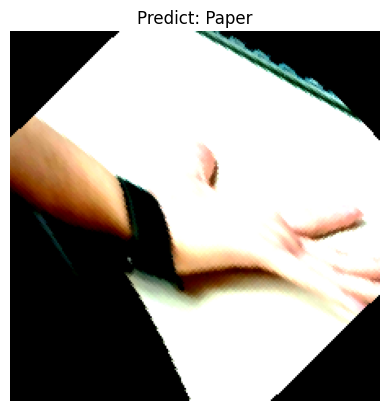

Average test Loss: 0.002192
Accuracy: 2537/2642 (96.03%)
Model saved
Model saved with test loss: 0.002192
Model saved with accuracy: 96.03%

Epoch: 9
Average train Loss: 0.001578


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(227, 227, 3)
(227, 227, 3)
(227, 227, 3)


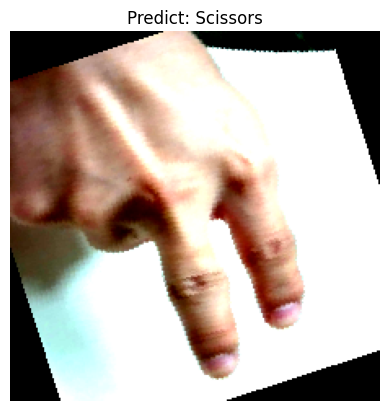

Average test Loss: 0.002021
Accuracy: 2543/2642 (96.25%)
Model saved
Model saved with test loss: 0.002021
Model saved with accuracy: 96.25%



In [14]:
# define the variables to store the lower test loss 
lowerst_test_loss = float('inf')

# train the model
for epoch in range(1, 10):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, device, test_loader)
    if test_loss < lowerst_test_loss:
            lowerst_test_loss = test_loss
            torch.save(model.state_dict(), 'Trained_Models/model_ResNet50_best.pth')
            print('Model saved')
            print('Model saved with test loss: {:.6f}'.format(test_loss))
            print('Model saved with accuracy: {:.2f}%'.format(accuracy))
            print()

In [ ]:
# # print the model weights
# weights = torch.load('Trained_Models/model_ResNet50_best.pth')# 打印模型权重
# for name, param in weights.items():
#     print('Layer: ', name)
#     print('Size: ', param.size())
#     print('\n')